## This notebook functions as downstream processing of all Illumina WGS outputs 
Filtering of Pindel, Caveman, GRIDSS, GRIPSS and BRASS covered

In [ ]:
### import needed packages - pysam, pandas, pycircos, matplotlib, scipy
import pysam
import pandas as pd
import re
import scipy.sparse as sp
from scipy.sparse import csr_matrix 
import matplotlib
import matplotlib.pyplot as plt
import pycircos
from pycircos.pycircos import Garc
from pycircos.pycircos import Gcircle
import os
import glob

In [ ]:
# define base directory
base_dir = "/lustre/scratch126/cellgen/behjati/lr26/WGS/"

In [ ]:
# import annotated vcf file and parse it using pysam 
vcf_file = base_dir + "PD54858d.v1.brass.annot.vcf.gz"
vcf = pysam.VariantFile(vcf_file)

records = []
# defining the columns in pysam 
for rec in vcf.fetch():
    record = {
        "chrom": rec.chrom,
        "pos": rec.pos,
        "id": rec.id,
        "ref": rec.ref,
        "alt": ",".join(str(a) for a in rec.alts),
        "qual": rec.qual,
        "svtype": rec.info.get("SVTYPE"),
        "supporting_reads": rec.info.get("AS", 0),  # tag for supporting reads
        "filter": rec.filter.keys()
    }
    records.append(record)
# then into dataframe
df = pd.DataFrame(records)
# visualise dataframe and find out there are only two low qual supporting variants in the whole file
df
# hence comment out all other filtering steps
#df_filtered = df[(df["qual"] > 30) & (df["supporting_reads"] >= 5)]
#print(df_filtered.head())


,chrom,pos,id,ref,alt,qual,svtype,supporting_reads,filter
0,chr20,45042796,74_2,A,A[chr7:81359101[,4.0,BND,1,[]
1,chr7,81359101,74_1,T,]chr20:45042796]T,4.0,BND,0,[]


In [ ]:
df.to_csv(base_dir + "brass_annot_tumor.csv", sep=",", index=False)
## optionally save the unmodified output to a csv

In [ ]:
# repeat the same process with the gripss output file
vcf_file = base_dir + "PD54858d.v1.gripss.filtered.vcf.gz"
vcf = pysam.VariantFile(vcf_file)

records = []

for rec in vcf.fetch():
    record = {
        "chrom": rec.chrom,
        "pos": rec.pos,
        "id": rec.id,
        "ref": rec.ref,
        "alt": ",".join(str(a) for a in rec.alts),
        "qual": rec.qual,
        "svtype": rec.info.get("SVTYPE"),
        "supporting_reads": rec.info.get("AS", 0), 
        "filter": rec.filter.keys()
    }
    records.append(record)
# here since it has better quality output filter by no of supporting reads which are more than one because otherwise it can be an artifact
df = pd.DataFrame(records)
df = df[df['supporting_reads'] >= 2]
# pring the dataframe
print(df)

                            chrom      pos                 id ref  \
8                            chr1  1207339     gridss0fb_502o   G   
9                            chr1  1207761     gridss0fb_502h   C   
20                           chr1  2121519    gridss0fb_1112o   A   
24                           chr1  2994978    gridss0fb_1684o   A   
25                           chr1  2995293    gridss0fb_1684h   T   
...                           ...      ...                ...  ..   
24863  chrUn_JTFH01001472v1_decoy     1433   gridss268ff_124h   N   
24897  chrUn_JTFH01001589v1_decoy     1166  gridss135bf_1201h   G   
24898  chrUn_JTFH01001591v1_decoy       38   gridss254bb_196h   N   
24908  chrUn_JTFH01001634v1_decoy       50    gridss3fb_3111h   T   
24910  chrUn_JTFH01001638v1_decoy     1090    gridss52bf_939h   G   

                                                    alt         qual svtype  \
8                                       G[chr1:1207761[   816.320007    BND   
9            

In [ ]:
# this is a setup I use for structural variants throughout to be fit for pycircos input
def parse_alt(alt):
    # depending on the vcf I use regex to extract chromosome and position from altALT field
    match = re.search(r'[\[\]]?([ACGTN]{0,20}?)?(chr[\wXYM]+):(\d+)[ACGTN]{0,20}?[\[\]]?', str(alt))
    if match:
        return match.group(2), int(match.group(3))  # chromosome, position in 2 and 3
    return None, None

# here I am parsing to extract alt, chr2 and start2
df[['chr2', 'start2']] = df['alt'].dropna().apply(lambda alt: pd.Series(parse_alt(alt)))

print(df[['alt', 'chr2', 'start2']].head())

# I need to create ends as in a bed file for plotting by pycircos whcih are both just shifted by a nucleotide
df['end1'] = df['pos'] + 1
df['end2'] = df['start2'] + 1

# I am renaming the columns as I need them (chrom and pos will become chr1 and start1)
df = df[['chrom', 'pos', 'end1', 'chr2', 'start2', 'end2']].rename(
    columns={'chrom': 'chr1', 'pos': 'start1'}
)

print(df.head())

# filter out rows that do not have th other chrom 
df = df[df['chr2'].notnull() & (df['chr2'] != '')]

# Define valid chromosomes
valid_chroms = [f'chr{i}' for i in range(1, 23)] + ['chrX']

# Keep only rows where chr1 and chr2 are both in valid list
df = df[df['chr1'].isin(valid_chroms) & df['chr2'].isin(valid_chroms)]


# Filter to only inter-chromosomal BNDs (where chr1 != chr2)
df_filtered = df[df['chr1'] != df['chr2']].copy()

print(f"Filtered to inter-chromosomal BNDs with valid chr2: {len(df_filtered)} rows")
df_filtered


🔍 After ALT Parsing:
                                                 alt  chr2   start2
8                                    G[chr1:1207761[  chr1  1207761
9                                    ]chr1:1207339]C  chr1  1207339
20  AGGTCATGGTGGTAGTTAGGGTTATGGTAGTTAG[chr1:2121520[  chr1  2121520
24                                   A[chr1:2995293[  chr1  2995293
25                                   ]chr1:2994978]T  chr1  2994978
🔍 Final DataFrame:
    chr1   start1     end1  chr2   start2     end2
8   chr1  1207339  1207340  chr1  1207761  1207762
9   chr1  1207761  1207762  chr1  1207339  1207340
20  chr1  2121519  2121520  chr1  2121520  2121521
24  chr1  2994978  2994979  chr1  2995293  2995294
25  chr1  2995293  2995294  chr1  2994978  2994979
Filtered to inter-chromosomal BNDs with valid chr2: 50 rows


,chr1,start1,end1,chr2,start2,end2
130,chr1,13299454,13299455,chr6,33062526,33062527
374,chr1,47338516,47338517,chr6,45904646,45904647
689,chr1,84052263,84052264,chr5,29576327,29576328
920,chr1,118858572,118858573,chr15,50897104,50897105
1025,chr1,164271325,164271326,chr2,190134717,190134718
1794,chr2,11789892,11789893,chr4,161132098,161132099
3056,chr2,203191330,203191331,chr9,129429539,129429540
3273,chr2,230497605,230497606,chr17,79652611,79652612
3771,chr3,53141869,53141870,chr1,168217251,168217252
3804,chr3,56782518,56782519,chr5,14306165,14306166


In [66]:
df_filtered.to_csv(base_dir + "gripss_filtered_tumor_rearrangements_interchrom_filt.csv", sep = ",", index=False)

In [ ]:
# Data as a list of lists
data = [
    ["chr1", 1, 248956422],
    ["chr2", 1, 242193529],
    ["chr3", 1, 198295559],
    ["chr4", 1, 190214555],
    ["chr5", 1, 181538259],
    ["chr6", 1, 170805979],
    ["chr7", 1, 159345973],
    ["chr8", 1, 145138636],
    ["chr9", 1, 138394717],
    ["chr10", 1, 133797422],
    ["chr11", 1, 135086622],
    ["chr12", 1, 133275309],
    ["chr13", 1, 114364328],
    ["chr14", 1, 107043718],
    ["chr15", 1, 101991189],
    ["chr16", 1, 90338345],
    ["chr17", 1, 83257441],
    ["chr18", 1, 80373285],
    ["chr19", 1, 58617616],
    ["chr20", 1, 64444167],
    ["chr21", 1, 46709983],
    ["chr22", 1, 50818468],
    ["chrX", 1, 156040895],
    ["chrY", 1, 57227415],
    ["chrM", 1, 16569]
]

# Create DataFrame
df_chrom_sizes = pd.DataFrame(data, columns=["Chromosome", "Start", "End"])

# Save to CSV
df_chrom_sizes.to_csv(base_dir + "chrom_sizes.csv", index=False)

print("✅ CSV file saved as 'chrom_sizes.csv'")


✅ CSV file saved as 'chrom_sizes.csv'


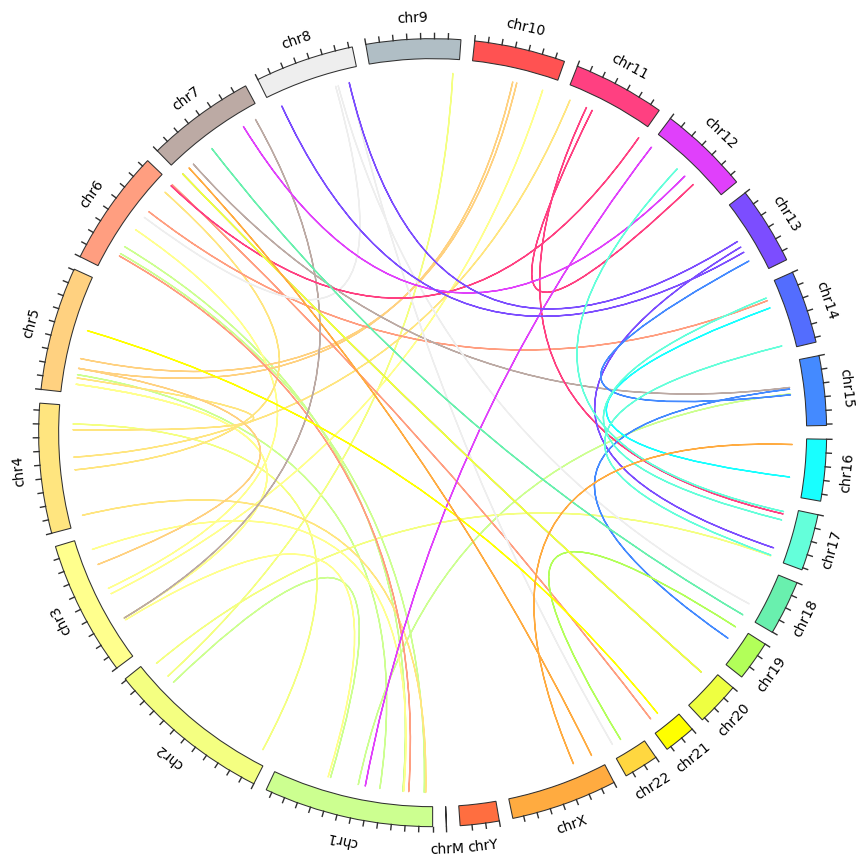

In [ ]:
#Set chromosomes
circle = Gcircle(figsize=(8,8)) 
with open(base_dir + "chrom_sizes.csv") as f:
    f.readline()
    for line in f:
        line   = line.rstrip().split(",") 
        name   = line[0]
        length = int(line[-1]) 
        arc    = Garc(arc_id=name, size=length, interspace=2, raxis_range=(935,985), labelposition=80, label_visible=True)
        circle.add_garc(arc) 
        
circle.set_garcs(-180, 180)  # Ensure full circle

for arc_id in circle.garc_dict:
    circle.tickplot(arc_id, raxis_range=(985,1000), tickinterval=20000000, ticklabels=None)

with open(base_dir + "gripss_filtered_tumor_rearrangements_interchrom_filt.csv") as f:
    next(f)  # Skip header line
    for line in f:
        line = line.rstrip().split(",")
        name1, start1, end1 = line[0], int(line[1]), int(line[2])
        name2, start2, end2 = line[3], int(line[4]), int(line[5])

        # Get facecolors from the arc dictionary
        facecolor1 = circle.garc_dict[name1].facecolor if name1 in circle.garc_dict else "gray"
        facecolor2 = circle.garc_dict[name2].facecolor if name2 in circle.garc_dict else "gray"

        # Draw the chord
        source = (name1, start1, end1, 900)
        destination = (name2, start2, end2, 900)
        circle.chord_plot(source, destination, facecolor=facecolor1, edgecolor=facecolor1, linewidth=1)
        
circle.figure.savefig(base_dir + "gripss_bnd_tumor_filt.pdf", dpi=300, bbox_inches="tight")

In [70]:

vcf_file = base_dir + "PD54858d.v1.gridss.vcf.gz"
vcf = pysam.VariantFile(vcf_file)

records = []

for rec in vcf.fetch():
    record = {
        "chrom": rec.chrom,
        "pos": rec.pos,
        "id": rec.id,
        "ref": rec.ref,
        "alt": ",".join(str(a) for a in rec.alts),
        "qual": rec.qual,
        "svtype": rec.info.get("SVTYPE"),
        "supporting_reads": rec.info.get("AS", 0),  # example GRIDSS tag for supporting reads
        "filter": rec.filter.keys()
    }
    records.append(record)

df = pd.DataFrame(records)
df = df[df['supporting_reads'] >= 2]

print(df)

                             chrom      pos                id ref  \
32                            chr1   789921    gridss0fb_144o   C   
186                           chr1  1007755    gridss0fb_387o   T   
187                           chr1  1007771    gridss0fb_387h   T   
263                           chr1  1157288    gridss0fb_478o   C   
269                           chr1  1157336    gridss0fb_484o   C   
...                            ...      ...               ...  ..   
615884  chrUn_JTFH01001680v1_decoy      253   gridss383fb_31o   C   
616642  chrUn_JTFH01001888v1_decoy     1599   gridss389fb_39o   G   
616818  chrUn_JTFH01001928v1_decoy     2149   gridss390fb_17o   G   
616912  chrUn_JTFH01001929v1_decoy     2151  gridss390fb_190o   A   
616918  chrUn_JTFH01001929v1_decoy     2286  gridss390fb_196h   A   

                                                      alt         qual svtype  \
32                               CGAATGGAATG[chr1:789922[  1248.739990    BND   
186      

In [ ]:
def parse_alt(alt):
    # Regex to extract chromosome and position from ALT field
    match = re.search(r'[\[\]]?([ACGTN]{0,20}?)?(chr[\wXYM]+):(\d+)[ACGTN]{0,20}?[\[\]]?', str(alt))
    if match:
        return match.group(2), int(match.group(3))  # chromosome, position
    return None, None

# Assuming df is your DataFrame with an 'alt' column
df[['chr2', 'start2']] = df['alt'].dropna().apply(lambda alt: pd.Series(parse_alt(alt)))

print("🔍 After ALT Parsing:")
print(df[['alt', 'chr2', 'start2']].head())

# Create 'end1' and 'end2' columns (assuming end = start + 1 for BND breakpoints)
df['end1'] = df['pos'] + 1
df['end2'] = df['start2'] + 1

# Select and rename columns as needed
df = df[['chrom', 'pos', 'end1', 'chr2', 'start2', 'end2']].rename(
    columns={'chrom': 'chr1', 'pos': 'start1'}
)

print("🔍 Final DataFrame:")
print(df.head())

# Filter out rows missing chr2
df = df[df['chr2'].notnull() & (df['chr2'] != '')]

# Define valid chromosomes
valid_chroms = [f'chr{i}' for i in range(1, 23)] + ['chrX']

# Keep only rows where chr1 and chr2 are both in valid list
df = df[df['chr1'].isin(valid_chroms) & df['chr2'].isin(valid_chroms)]


# Filter to only inter-chromosomal BNDs (where chr1 != chr2)
df_filtered = df[df['chr1'] != df['chr2']].copy()

print(f"Filtered to inter-chromosomal BNDs with valid chr2: {len(df_filtered)} rows")
df_filtered


🔍 After ALT Parsing:
                                                   alt  chr2   start2
32                            CGAATGGAATG[chr1:789922[  chr1   789922
186                                    T[chr1:1007771[  chr1  1007771
187                                    ]chr1:1007755]T  chr1  1007755
263  CCCCGCCCCCAGCCCACCCATCCCATCCCCGCCATCCCCG[chr1:...  chr1  1157328
269                                    C[chr1:1157347[  chr1  1157347
🔍 Final DataFrame:
     chr1   start1     end1  chr2   start2     end2
32   chr1   789921   789922  chr1   789922   789923
186  chr1  1007755  1007756  chr1  1007771  1007772
187  chr1  1007771  1007772  chr1  1007755  1007756
263  chr1  1157288  1157289  chr1  1157328  1157329
269  chr1  1157336  1157337  chr1  1157347  1157348
Filtered to inter-chromosomal BNDs with valid chr2: 101 rows


,chr1,start1,end1,chr2,start2,end2
2112,chr1,6312820,6312821,chr2,208098598,208098599
4135,chr1,13299454,13299455,chr6,33062526,33062527
12839,chr1,47338516,47338517,chr6,45904646,45904647
18367,chr1,80938744,80938745,chr4,103293341,103293342
18843,chr1,84052263,84052264,chr5,29576327,29576328
...,...,...,...,...,...,...
535048,chr21,10403598,10403599,chr22,11055982,11055983
537638,chr21,24841845,24841846,chr5,101161558,101161559
546561,chr22,23735647,23735648,chr7,84299805,84299806
557940,chrX,11935080,11935081,chr7,17055077,17055078


In [72]:
df_filtered.to_csv(base_dir + "gridss_filtered_tumor_rearrangements_interchrom_filt.csv", sep = ",", index=False)

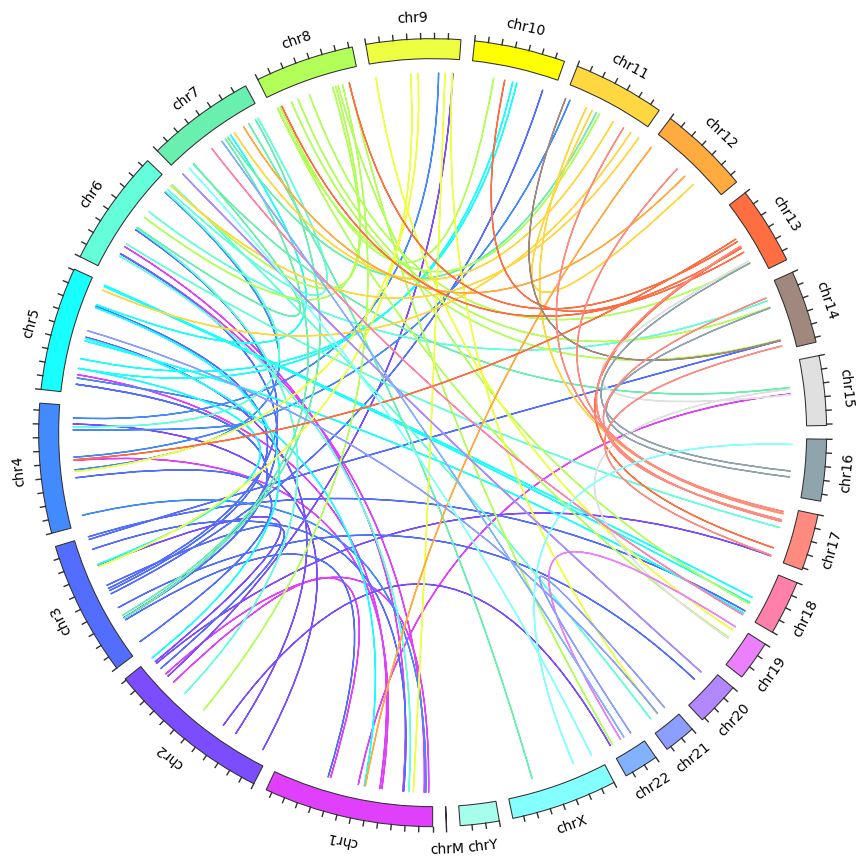

In [ ]:

circle = Gcircle(figsize=(8,8)) 
with open(base_dir + "chrom_sizes.csv") as f:
    f.readline()
    for line in f:
        line   = line.rstrip().split(",") 
        name   = line[0]
        length = int(line[-1]) 
        arc    = Garc(arc_id=name, size=length, interspace=2, raxis_range=(935,985), labelposition=80, label_visible=True)
        circle.add_garc(arc) 
        
circle.set_garcs(-180, 180)  # Ensure full circle

for arc_id in circle.garc_dict:
    circle.tickplot(arc_id, raxis_range=(985,1000), tickinterval=20000000, ticklabels=None)

with open(base_dir + "gridss_filtered_tumor_rearrangements_interchrom_filt.csv") as f:
    next(f)  # Skip header line
    for line in f:
        line = line.rstrip().split(",")
        name1, start1, end1 = line[0], int(line[1]), int(line[2])
        name2, start2, end2 = line[3], int(line[4]), int(line[5])

        # Get facecolors from the arc dictionary
        facecolor1 = circle.garc_dict[name1].facecolor if name1 in circle.garc_dict else "gray"
        facecolor2 = circle.garc_dict[name2].facecolor if name2 in circle.garc_dict else "gray"

        # Draw the chord
        source = (name1, start1, end1, 900)
        destination = (name2, start2, end2, 900)
        circle.chord_plot(source, destination, facecolor=facecolor1, edgecolor=facecolor1, linewidth=1)
        
circle.figure.savefig(base_dir + "gridss_bnd_tumor_filt.pdf", dpi=300, bbox_inches="tight")

In [ ]:
# Load both CSVs
df1 = pd.read_csv(base_dir + "gridss_filtered_tumor_rearrangements_interchrom_filt.csv")
df2 = pd.read_csv(base_dir + "gripss_filtered_tumor_rearrangements_interchrom_filt.csv")

# Merge on all breakpoint columns
merged = pd.merge(df1, df2, on=['chr1', 'start1', 'end1', 'chr2', 'start2', 'end2'])

print(f"Found {len(merged)} exact overlaps.")
print(merged.head())

Found 50 exact overlaps.
   chr1     start1       end1   chr2     start2       end2
0  chr1   13299454   13299455   chr6   33062526   33062527
1  chr1   47338516   47338517   chr6   45904646   45904647
2  chr1   84052263   84052264   chr5   29576327   29576328
3  chr1  118858572  118858573  chr15   50897104   50897105
4  chr1  164271325  164271326   chr2  190134717  190134718


In [76]:
merged.to_csv(base_dir + "gridss_gripps_filtered_tumor_rearrangements_interchrom_filt.csv", sep = ",", index=False)

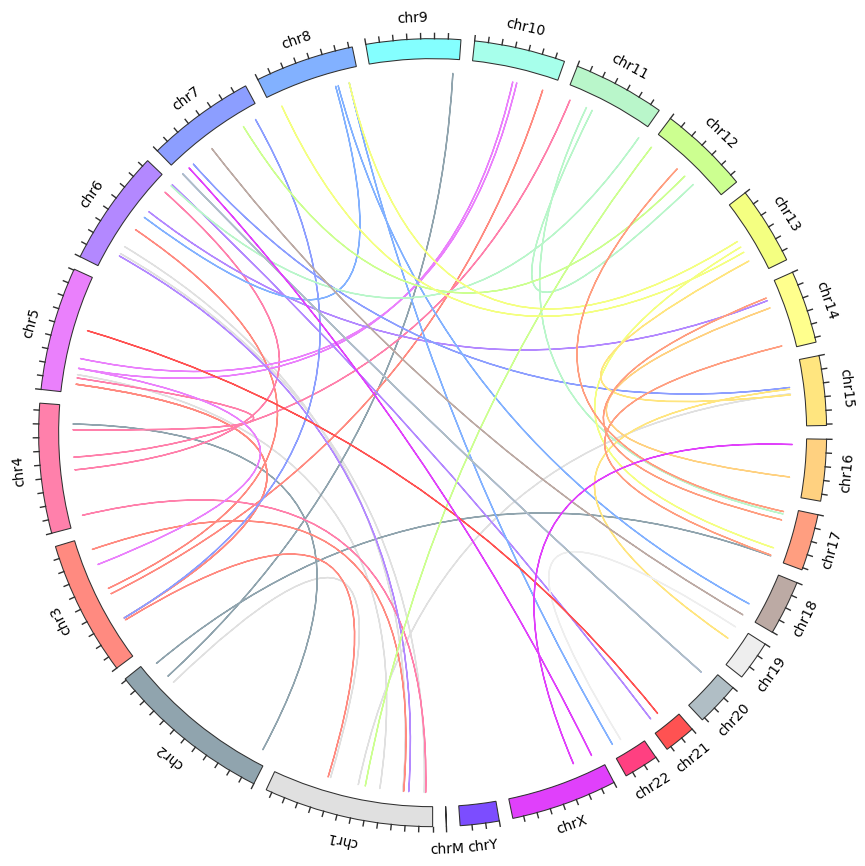

In [ ]:
circle = Gcircle(figsize=(8,8)) 
with open(base_dir + "chrom_sizes.csv") as f:
    f.readline()
    for line in f:
        line   = line.rstrip().split(",") 
        name   = line[0]
        length = int(line[-1]) 
        arc    = Garc(arc_id=name, size=length, interspace=2, raxis_range=(935,985), labelposition=80, label_visible=True)
        circle.add_garc(arc) 
        
circle.set_garcs(-180, 180)  # Ensure full circle

for arc_id in circle.garc_dict:
    circle.tickplot(arc_id, raxis_range=(985,1000), tickinterval=20000000, ticklabels=None)

with open(base_dir + "gridss_gripps_filtered_tumor_rearrangements_interchrom_filt.csv") as f:
    next(f)  # Skip header line
    for line in f:
        line = line.rstrip().split(",")
        name1, start1, end1 = line[0], int(line[1]), int(line[2])
        name2, start2, end2 = line[3], int(line[4]), int(line[5])

        # Get facecolors from the arc dictionary
        facecolor1 = circle.garc_dict[name1].facecolor if name1 in circle.garc_dict else "gray"
        facecolor2 = circle.garc_dict[name2].facecolor if name2 in circle.garc_dict else "gray"

        # Draw the chord
        source = (name1, start1, end1, 900)
        destination = (name2, start2, end2, 900)
        circle.chord_plot(source, destination, facecolor=facecolor1, edgecolor=facecolor1, linewidth=1)
        
circle.figure.savefig(base_dir + "gridss_grips_bnd_tumor_filt.pdf", dpi=300, bbox_inches="tight")

In [ ]:
vcf = pysam.VariantFile(base_dir + "PD54858d.v1.caveman_c.annot.vcf.gz")
records = []

for rec in vcf.fetch():
    gene = rec.info.get('VD', None)  # Extract gene name from VD field
    record = {
        "chrom": rec.chrom,
        "pos": rec.pos,
        "ref": rec.ref,
        "alt": ",".join(rec.alts),
        "filter": list(rec.filter.keys()),
        "gene": gene
    }
    records.append(record)

df = pd.DataFrame(records)
# Filter to keep only variants with a non-null, non-empty VD field (gene name)
df = df[
    (df['gene'].notnull()) & 
    (df['gene'] != '') & 
    (df['filter'].apply(lambda f: 'PASS' in f))
]

df

,chrom,pos,ref,alt,filter,gene
795,chr1,20978679,A,C,[PASS],EIF4G3|CCDS55580.1|r.?|-|-|protein_coding:intr...
1066,chr1,36910563,A,T,[PASS],GRIK3|CCDS416.1|r.?|-|-|protein_coding:intron:...
3463,chr1,234598364,T,A,[PASS],U8|ENST00000390842|r.?|-|-|non_protein_coding:...
3544,chr1,240208115,T,A,[PASS],FMN2|CCDS31069.2|r.3530u>a|c.3303T>A|p.P1101P|...
5410,chr10,76526867,T,G,[PASS],LRMDA|CCDS76319.1|r.?|-|-|protein_coding:intro...
...,...,...,...,...,...,...
48266,chr8,133214096,A,C,[PASS],CCN4|CCDS6371.1|r.?|-|-|protein_coding:intron:...
51433,chr9,92947063,C,G,[PASS],FGD3|CCDS43849.1|r.?|-|-|protein_coding:substi...
51456,chr9,94895243,A,T,[PASS],AOPEP|CCDS55328.1|r.?|-|-|protein_coding:intro...
54435,chrX,150652647,G,A,[PASS],MTM1|CCDS14694.1|r.?|-|-|protein_coding:intron...


In [83]:
df.to_csv(base_dir + "caveman_annot_pass_genes_filtered_tumor.csv", sep = ",", index=False)

In [ ]:
vcf = pysam.VariantFile(base_dir + "PD54858d.v1.pindel.annot.vcf.gz")
records = []

for rec in vcf.fetch():
    gene = rec.info.get('VD', None)  # Extract gene name from VD field
    record = {
        "chrom": rec.chrom,
        "pos": rec.pos,
        "ref": rec.ref,
        "alt": ",".join(rec.alts),
        "filter": list(rec.filter.keys()),
        "gene": gene
    }
    records.append(record)

df = pd.DataFrame(records)
# Filter to keep only variants with a non-null, non-empty VD field (gene name)
df = df[
    (df['gene'].notnull()) & 
    (df['gene'] != '') & 
    (df['filter'].apply(lambda f: 'PASS' in f))
]

df

,chrom,pos,ref,alt,filter,gene
12678,chr1,15458908,TAAAAAAAAAAAAAAAAAAAAAAAA,T,[PASS],CELA2A|CCDS157.1|r.?|-|-|protein_coding:intron...
184282,chr10,12416155,G,GT,[PASS],CAMK1D|CCDS7091.1|r.?|-|-|protein_coding:intro...
191207,chr10,19988776,CTTTTT,C,[PASS],PLXDC2|CCDS7132.1|r.?|-|-|protein_coding:intro...
352724,chr11,108850612,G,GA,[PASS],DDX10|CCDS8342.1|r.?|-|-|protein_coding:intron...
693825,chr16,15665452,C,CT,[PASS],NDE1|CCDS10564.1|r.?|-|-|protein_coding:intron...
791486,chr17,49676019,C,CA,[PASS],SPOP|CCDS11551.1|r.179-4_179-3insu|c.?|p.?|pro...
852999,chr18,49290367,T,TA,[PASS],DYM|CCDS11937.1|r.?|-|-|protein_coding:intron:...
882305,chr19,6281485,A,AT,[PASS],MLLT1|CCDS12160.1|r.?|-|-|protein_coding:inser...
1005173,chr2,98679425,AAAAAG,A,[PASS],MGAT4A|CCDS2036.1|r.?|-|-|protein_coding:intro...
1009920,chr2,105353410,A,AT,[PASS],FHL2|CCDS2070.1|r.?|-|-|protein_coding:inserti...


In [85]:
df.to_csv(base_dir + "pindel_annot_pass_genes_filtered_tumor.csv", sep = ",", index=False)